## The Dataset

For this empirical study, we will be using a small datasat named the "Road Sign Detection Dataset" from this Kaggle page (https://www.kaggle.com/datasets/andrewmvd/road-sign-detection).

This dataset contains 4 classifications of road sign:
- Traffic Light
- Stop
- Speedlimit
- Crosswalk

There are image samples 877 samples in total. This is a very small dataset for this kind of an application, but as this study is intended to show an example, it is appropriate.


## Examine the Samples

Let's first get a preview of some of the samples from the dataset.

/Users/nick/cv/blogs/traffic-blog/adversarial/traffic_signs/images
/Users/nick/cv/blogs/traffic-blog/adversarial/traffic_signs/annotations


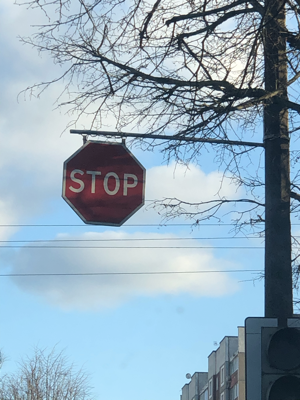

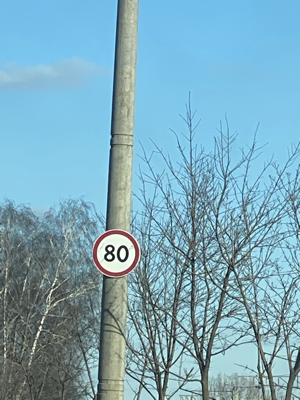

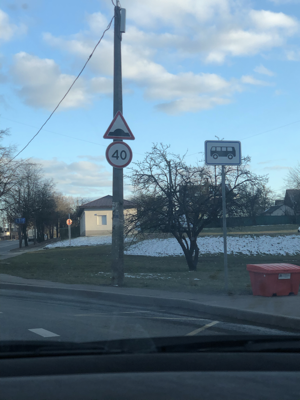

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


base_dir = os.environ['ADVERSARIAL_DIR']

image_dir = os.path.join(base_dir, 'traffic_signs/images')
anno_dir = os.path.join(base_dir, 'traffic_signs/annotations')
print(image_dir)
print(anno_dir)

img_files = []
for root, dirs, files in os.walk(image_dir):
    img_files = files

for i in range(3):
    img = Image.open(os.path.join(image_dir, img_files[i]))
    img = img.convert("RGB")
    display(img)



As shown above, the images consist of the pictures in their natural state, taken as someone would see them from the view of a car, in varying weather and lighting conditions.

Because this demo's topic is sign identification and not sign location, the bounding squares  that describe the location for the signs will be used as provided by the dataset instead of dynamically generating their location through any particular process.

In [2]:
import xml.etree.ElementTree as ET

'''
Example annotation file:

<annotation>
    <folder>images</folder>
    <filename>road0.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>98</xmin>
            <ymin>62</ymin>
            <xmax>208</xmax>
            <ymax>232</ymax>
        </bndbox>
    </object>
</annotation>
'''

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = []

    for obj in root.findall('object'):
        annotation = {}

        annotation['name'] = obj.find('name').text
        annotation['pose'] = obj.find('pose').text
        annotation['truncated'] = int(obj.find('truncated').text)
        annotation['occluded'] = int(obj.find('occluded').text)
        annotation['difficult'] = int(obj.find('difficult').text)

        bndbox = obj.find('bndbox')
        annotation['xmin'] = int(bndbox.find('xmin').text)
        annotation['ymin'] = int(bndbox.find('ymin').text)
        annotation['xmax'] = int(bndbox.find('xmax').text)
        annotation['ymax'] = int(bndbox.find('ymax').text)

        annotations.append(annotation)

    return annotations

annotations = {}

for root, dirs, files in os.walk(anno_dir):
    for file in files:
        if ('xml' in file):
            annotations[file[:file.find('.')]] = parse_annotation(os.path.join(anno_dir, file))

print(annotations['road0'])


[{'name': 'trafficlight', 'pose': 'Unspecified', 'truncated': 0, 'occluded': 0, 'difficult': 0, 'xmin': 98, 'ymin': 62, 'xmax': 208, 'ymax': 232}]


In [3]:
# sanity checking to ensure all labels are correct
for image in annotations:
    for obj in annotations[image]:
        labels = ['crosswalk', 'stop', 'speedlimit', 'trafficlight']
        label = obj['name']
        if (label not in labels):
            print(label)
        


In [4]:
import cv2

def extract_images(anno_dict, save_size):
    bad_images = 0
    good_images = 0
    for image in anno_dict:
        for i, obj in enumerate(anno_dict[image]):
            xmin = obj['xmin']
            xmax = obj['xmax']
            ymin = obj['ymin']
            ymax = obj['ymax']
        
            # because we want a square around the image, we'll first extract the largest 
            # square around the targest as possible.
            xdiff = xmax-xmin
            ydiff = ymax-ymin
            total_diff = (ydiff - xdiff) // 2
            if (xdiff > ydiff):
                # The target is horizontally larger
                # increase the y bounds slightly to accomodate a square
                ymax += total_diff
                ymin -= total_diff
            else:
                # Likewise if the image is vertically larger
                # we should increase the x bounds to house the image within a square
                xmax += total_diff
                xmin -= total_diff

            image_path = os.path.join(image_dir, image + '.png')
            cv_image = cv2.imread(image_path)

            roi = cv_image[ymin:ymax, xmin:xmax]

            # we have extracted the bounding square, lets save the result.
            # first make a new images folder with appropriate labels
            # if we haven't seen the label before, make a new folder
            label = obj['name']
            label_dir = os.path.join(base_dir, 'classifications', label)
            if (not os.path.exists(label_dir)):
                os.makedirs(label_dir)

            # place the new image into the saved folder
            file_name = str(image + str(i) + '.png')
            save_fn = os.path.join(label_dir, file_name)
            try:
                out = cv2.resize(roi, save_size)
                cv2.imwrite(save_fn, out)
                good_images += 1
            except Exception as e:
                bad_images += 1
    print("Total Failed Images: " + str(bad_images))
    print("Total Saved Images: " + str(good_images))
save_size = (32,32)
extract_images(annotations, save_size)

Total Failed Images: 13
Total Saved Images: 1231


We have constructed a new dataset comprised of objects that were extracted from the above Traffic Sign dataset stored in Kaggle. Because each of the **877** images can contain multiple objects that need to be classified, were left with **1231** total classifiable images.

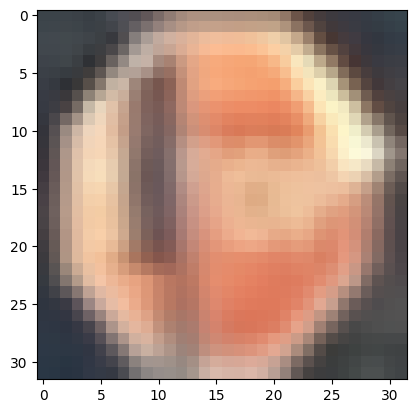

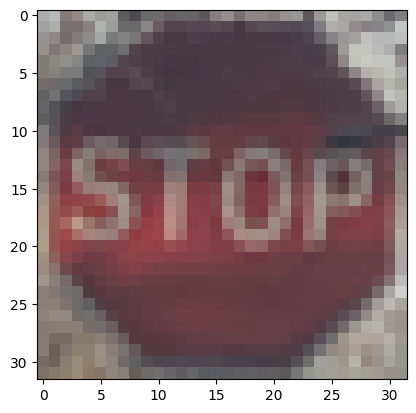

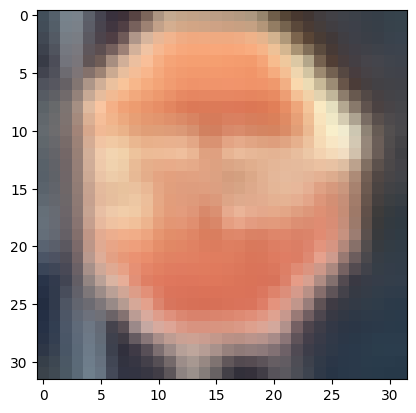

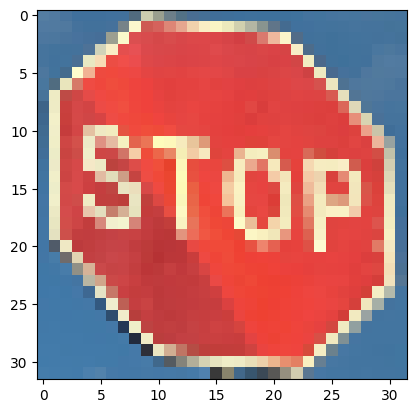

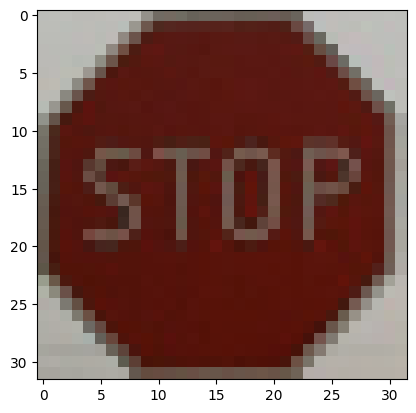

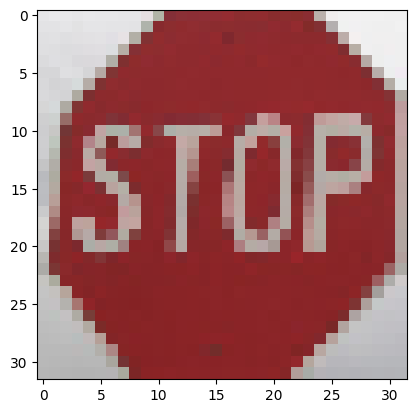

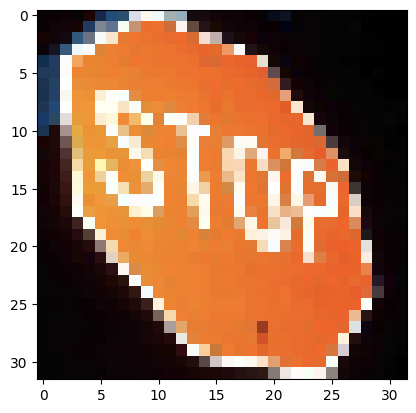

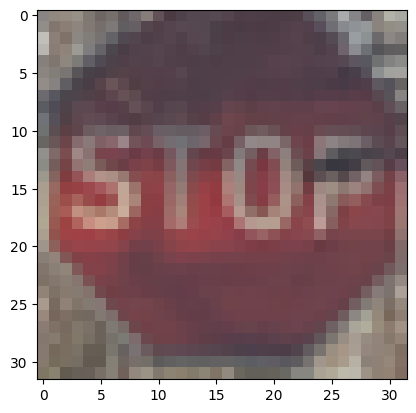

In [5]:
# Sanity check some of the images
import random
from PIL import Image

display_num = 8

image_paths = []
for root, dirs, files in os.walk(os.path.join(base_dir, 'classifications/stop')):
    for f in files:
        if '.png' in f:
            image_paths.append(os.path.join(root, f))
            
image_selection = random.sample(image_paths, display_num)
images = [Image.open(x) for x in image_selection]

for im in images:
    plt.figure()
    plt.imshow(im)
    

Although the above images look chunky, lets remember that processing power increases with an increase in total input parameters. For this example, let's keep the images simple.

Next, we should clean our data, to ensure it's all processable by our machine learning model. In this example, we will be using a simple Convolutional Neural Network to process our images. 

As we learned before, CNNs require standardized input, i.e. we need all of our images to be squares. Let's convert all the images that were produced into 32x32 squares.

# Training

In [6]:
# I ripped the entire training procedure from this website:
# https://www.analyticsvidhya.com/blog/2021/12/traffic-signs-recognition-using-cnn-and-keras-in-python/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
from PIL import Image
import os 
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

2023-10-05 10:29:36.714372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [60]:
data = []
labels = []
classes = 4 
cur_path = os.getcwd() 

for i in range(classes): 
    path = os. path.join(cur_path, 'train', str(i)) 
    images = os.listdir(path) 
    for a in images: 
        image = Image.open(path + '/' + a) 
        # image = image.resize((30,30)) 
        image = np.array(image)/255 
        data.append(image) 
        labels.append(i) 
            
data = np.array(data)
labels = np.array(labels)

In [61]:
print(data.shape, labels.shape)
#Splitting training and testing dataset
X_t1, X_t2, y_t1, y_t2 = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_t1.shape, X_t2.shape, y_t1.shape, y_t2.shape)
#Converting the labels into one hot encoding
y_t1 = to_categorical(y_t1, 4)
y_t2 = to_categorical(y_t2, 4)

(1231, 32, 32, 3) (1231,)
(984, 32, 32, 3) (247, 32, 32, 3) (984,) (247,)


In [62]:
#Building the model 
model = Sequential() 
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_t1.shape[1:])) 
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2))) 
model.add(Dropout(rate=0.25)) 
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu')) 
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu')) 
model.add(MaxPool2D(pool_size=(2, 2))) 
model.add(Dropout(rate=0.25)) 
model.add(Flatten()) 
model.add(Dense(256, activation='relu')) 
model.add(Dropout(rate=0.5)) 
model.add(Dense(4, activation='softmax')) 
#Compilation of the model 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

eps = 15
anc = model.fit(X_t1, y_t1, batch_size=32, epochs=eps, validation_data=(X_t2, y_t2))
model.save("my_model.h5")

Epoch 1/15
31/31 [==============================] - 3s 70ms/step - loss: 1.0561 - accuracy: 0.6138 - val_loss: 0.9006 - val_accuracy: 0.6599
Epoch 2/15
31/31 [==============================] - 2s 66ms/step - loss: 0.6214 - accuracy: 0.7581 - val_loss: 0.1738 - val_accuracy: 0.9433
Epoch 3/15
31/31 [==============================] - 2s 65ms/step - loss: 0.2574 - accuracy: 0.9146 - val_loss: 0.0914 - val_accuracy: 0.9838
Epoch 4/15
31/31 [==============================] - 2s 65ms/step - loss: 0.1406 - accuracy: 0.9563 - val_loss: 0.0633 - val_accuracy: 0.9879
Epoch 5/15
31/31 [==============================] - 2s 64ms/step - loss: 0.1122 - accuracy: 0.9685 - val_loss: 0.0826 - val_accuracy: 0.9757
Epoch 6/15
31/31 [==============================] - 2s 65ms/step - loss: 0.0904 - accuracy: 0.9766 - val_loss: 0.0471 - val_accuracy: 0.9798
Epoch 7/15
31/31 [==============================] - 2s 67ms/step - loss: 0.0728 - accuracy: 0.9776 - val_loss: 0.0529 - val_accuracy: 0.9838
Epoch 8/15
31

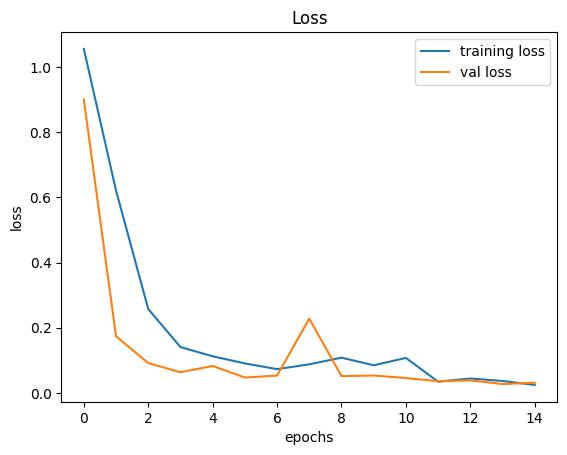

In [63]:
# plotting graphs for accuracy

plt.figure(0)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Normally, in a standard machine learning exercise, we'd have built a test set, and we'd be ready to evaluate our machine learning model on that test set to get a sense for how that model would perform in the real world.

For this exercise, we'll do a quick check to see if the model works, and move to fooling it with an adversarial attack.


In [64]:
label_names = ['crosswalk', 'speedlimit', 'stop', 'trafficlight']

image_paths = []
labels = []
for i in range(4):
    for root, dirs, files in os.walk(os.path.join(base_dir, 'train', str(i))):
        for f in files:
            if '.png' in f:
                image_paths.append(os.path.join(root, f))
                labels.append(i)

# print(len(image_paths))
display_num = 1
image_selection = random.sample(list(enumerate(image_paths)), display_num)
# print(image_selection)

images = [Image.open(x[1]) for x in image_selection]
label_inds = [x[0] for x in image_selection]
labels = [labels[x] for x in label_inds]
# print(labels)

1/1 [==============================] - 0s 20ms/step
0
speedlimit
Total Accuracy: 1.0


/var/folders/8v/1cqfw91x4m32jr2ch9n384wr0000gn/T/ipykernel_49289/183591168.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(label_names[int(pred_list[i])])


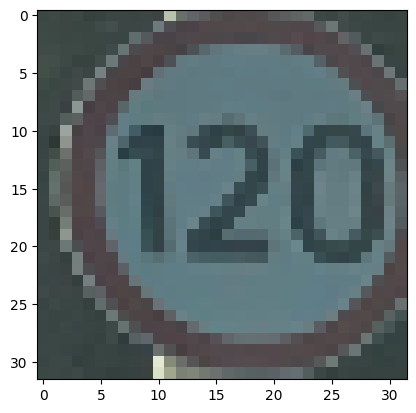

In [67]:
data=[]
for img in images:
    data.append(np.array(img))
    
    
X_test=np.array(data)

pred = model.predict(X_test)

pred_list = []
for p in pred:
    pred_list.append(np.where(p==max(p))[0])

# print(pred)
# print(labels)
# print(pred_list)
right = 0
for i in range(len(pred_list)):
    if (labels[i] == pred_list[i]):
        right+=1

for i, im in enumerate(images):
    print(i)
    plt.figure()
    plt.imshow(im)
    print(label_names[int(pred_list[i])])

print("Total Accuracy: " + str(right / len(labels)))

model.save('traffic_classifier.keras')#to save

Now we have a working, running machine learning model that can tell us information about traffic signs.

LET'S BREAK IT

## Adversarial Attack

In [68]:


# I ripped most of the following from here: 
# - https://fairyonice.github.io/Learn-the-Carlini-and-Wagners-adversarial-attack-MNIST.html
# - foolbox documentation
# - ChatGPT
# - StackOverflow

In [69]:
# Taking a look at our model

from keras.models import Sequential
from keras.layers import Input, Lambda,  Flatten

batch_size = 1
 
m = Sequential()

# newInput expect an image ranging [-0.5,0.5] --> need to transform to our range: [0,1] by multipying all the values by 2
m.add(Lambda(lambda x : x+0.5,name="rescaledm05p05", input_shape=X_t1.shape[1:]))


## start from 1 because we want to use new Input layer 
## end right before -1 because softmax should be removed. 
for l in model.layers[:-1]:
    #print(l.name)
    m.add(l)
#m.add(Flatten())
# https://github.com/keras-team/keras/issues/8909
model_rescaled = m
model_rescaled.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaledm05p05 (Lambda)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                      

In [74]:
import foolbox
from foolbox.attacks import FGSM
from foolbox.criteria import Misclassification

lb = tf.convert_to_tensor(labels)

# normalize
images = np.array(images)
images = images / 255
images = images.astype(np.float32)

fmodel = foolbox.models.TensorFlowEagerModel(model, bounds=(0, 1))


######################### Attacking the model ##########################

attack = foolbox.attacks.FGSM(fmodel, criterion=Misclassification())
img = np.array([images[0]])
label = np.array([labels[0]])
print(img.shape)
print(label.shape)
print(len(img))
print(len(label))
adversarial = np.array([attack(img, label)])
print(adversarial.shape)
model_predictions = model.predict(adversarial[0])
print('real label: {}, label prediction; {}'.format(
    labels[0], np.argmax(model_predictions)))

label_names = ['crosswalk', 'speedlimit', 'stop', 'trafficlight']
print("Actual Label: " + label_names[labels[0]])
print("Predicted Label: " + label_names[np.argmax(model_predictions)])



(1, 32, 32, 3)
(1,)
1
1
(1, 1, 32, 32, 3)
1/1 [==============================] - 0s 17ms/step
real label: 1, label prediction; 3
Actual Label: speedlimit
Predicted Label: trafficlight


We see from the above that the model incorrectly classified the sample.

Now, lets take a look at the image.

What does it look like to you!

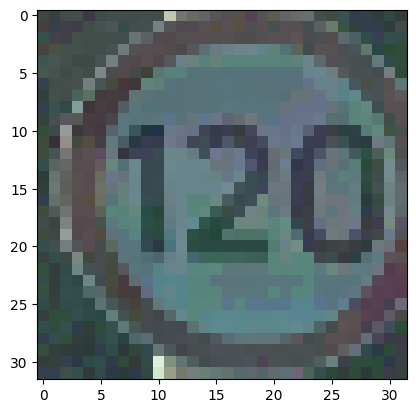

In [71]:
img = np.array(adversarial[0][0])

plt.figure()
plt.imshow(img)
# cv2.imwrite(new_path,img)